In [52]:
%pylab inline
import numpy as np
from astropy.table import Table, Column
from scipy.optimize import curve_fit
from IPython.display import display, Math, Latex
from scipy.integrate import odeint, quad
plt.style.use('seaborn-whitegrid')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Gravitational Lensing with a Point Source

The lensing equation is:

$$\beta = \theta - \frac{D_{LS}}{D_S D_L}\frac{4GM}{c^2 \theta}$$

Where $\beta$ is the true angle, $\theta$ is the apparent (or lensed) angle, $D_{LS}$ is the lens to source distance, $D_S$  is the observer to source distance, $D_L$ is the observer to lens distance, and M is the mass of the lens.

When a source is directly behind a lens, ($\beta$ = 0), then the source will appear to be distorted in a ring at a distance from the lens $\theta_E$, the Einstein radius. The equation for the Einstein radius is given by:

$$\theta_E = (\frac{4GM}{c^2}\frac{D_{LS}}{D_S D_L})^{1/2}$$

And the solutions for the apparent angle are given by:

$$\theta_{1,2} = \frac{1}{2}(\beta \pm \sqrt{\beta^2 + 4\theta_E^2}) $$

The magnification of the lensed light is given by:

$$M = (1 - \frac{\theta_E^4}{\theta^4})^{-1} $$

To define any of these equation and create a simulation, we must choose a mass for the lens. Since we are modelling it  as point source, we will use a galaxy as a model for the lens; specifically the Milky Way, because the mass is well determined.

In [53]:
M_lens = 6e42; #kg
G = 6.67e-11; #m^3/kg.s^2
c = 2.99e8 #m/s

This allows us to reduce the equation for the Einstein radius to a constant we'll call $N$, such that:

$$\theta_E = N(\frac{D_{LS}}{D_S D_L})^{1/2}$$

In [54]:
N = ((4*M_lens*G/(c**2.0))*3.24e-23)**(0.5); #Mpc^1/2
#if there is time write all the distances in nautical miles
print N

0.000761675268952


Now to determine the Einstein Radius we must establish a system such that we have the distances $D_{LS}$, $D_S$, and $D_L$. For now we'll just choose some values (and make this system editable later). Once we do that we can determine a value for $\theta_E$.

In [55]:
#D_s = D_ls + D_s
D_ls = 3.0; #Mpc
D_l = 5.0; #Mpc
D_s = 8.0; #Mpc
theta_E = N*((D_ls/D_s*D_l)**(0.5)); #unitless distance
print theta_E

0.00104296681575


To quantify this in pixels we'll decide that a pixel is 0.00001, so in this case theta_E is approximately 100 pixels.

In [56]:
pix = 0.00001;
tE_pix = theta_E/pix;
print tE_pix

104.296681575


Now we must define a grid system. Let's choose a map of 500 by 500 and center the lens at (0,0) and plot it with the Einstein ring at the Einstein radius.

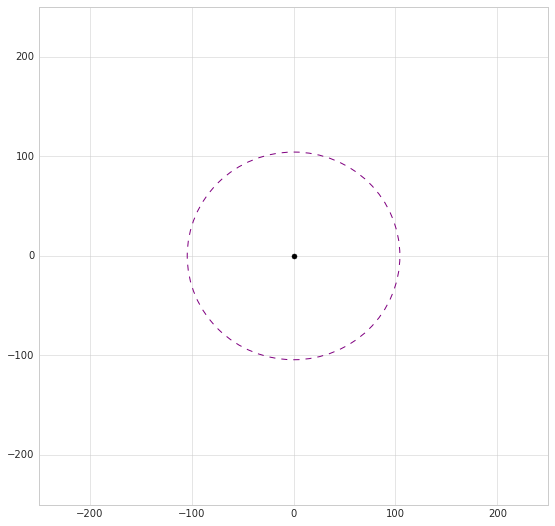

In [57]:
fig,ax = subplots(1,1)
fig.tight_layout()
fig.set_size_inches(8,8)

#lensing mass, calibration size of magnification: markersize=10
ax.set_xlim(-250,250);
ax.set_ylim(-250,250);
ax.plot(0,0,linestyle="none",marker=".", markersize=10,color="k")

#einstein ring
circ = plt.Circle((0,0), radius=tE_pix, linestyle="--",color='purple', fill=False)
ax.add_patch(circ);

Now we need to estimate a source as a blob in terms of points with x and y coordinates.

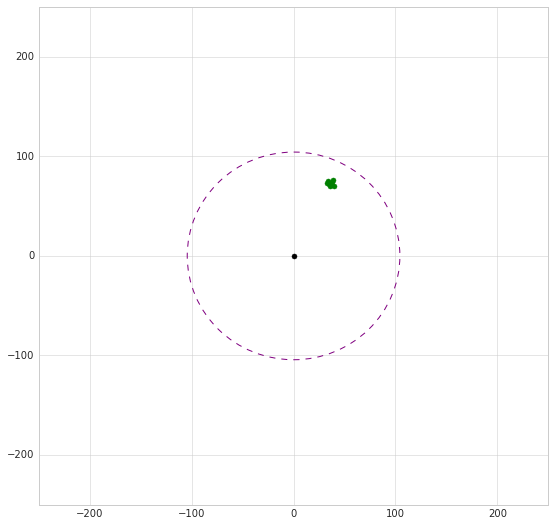

In [58]:
source_x = [33,34,35,36,37,38,39,40];
source_y = [73,75,72,70,71,74,76,70];

fig,ax = subplots(1,1)
fig.tight_layout()
fig.set_size_inches(8,8)

ax.set_xlim(-250,250);
ax.set_ylim(-250,250);
ax.plot(0,0,linestyle="none",marker=".", markersize=10,color="k");
ax.plot(source_x,source_y,linestyle="none",marker=".", markersize=10,color="g")

circ = plt.Circle((0,0), radius=tE_pix, linestyle="--",color='purple', fill=False)
ax.add_patch(circ);

Now, we know that the direction of the lensed image will be the same as the direction of the source, only the x and y coordinates will be amplified. If we think of it like a similar triangle we can realize that the new coordinates (x', y') are related to $\theta$, $\beta$, and the original coordinates (x, y) such that:

$$\frac{\theta}{\beta} = \frac{x'}{x} = \frac{y'}{y}$$

$$x' = \frac{\theta}{\beta}x \quad y' = \frac{\theta}{\beta}y$$

And we can determine $\beta$ from the original x and y coordinates using the Pythagorean Theorem:

$$\beta = \sqrt{x^2 + y^2}$$

In [61]:
xprime1 = [];
xprime2 = [];
yprime1 = [];
yprime2 = [];

i=0;
while i < len(source_x):
    x = source_x[i];
    y = source_y[i];
    beta = np.sqrt(x**2 + y**2);
    theta1 = 0.5*(beta + np.sqrt(beta**2+4*tE_pix**2));
    theta2 = 0.5*(beta - np.sqrt(beta**2+4*tE_pix**2));
    x1 = (theta1/beta)*x;
    y1 = (theta1/beta)*y;
    x2 = (theta2/beta)*x;
    y2 = (theta2/beta)*y;
    xprime1.append(x1);
    xprime2.append(x2);
    yprime1.append(y1);
    yprime2.append(y2);
    i += 1;

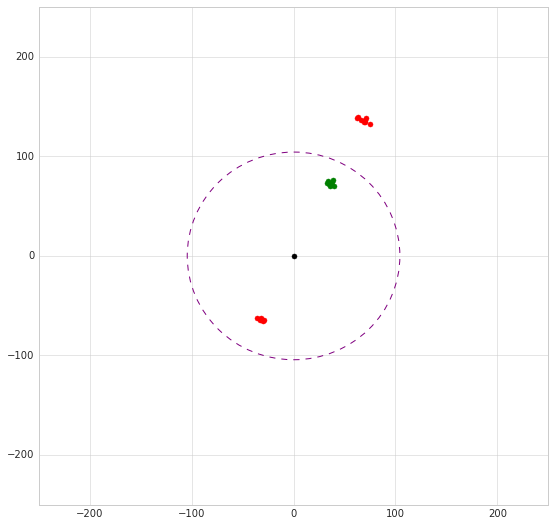

In [62]:
fig,ax = subplots(1,1)
fig.tight_layout()
fig.set_size_inches(8,8)

ax.set_xlim(-250,250);
ax.set_ylim(-250,250);
ax.plot(0,0,linestyle="none",marker=".", markersize=10,color="k");
ax.plot(source_x,source_y,linestyle="none",marker=".", markersize=10,color="g")

circ = plt.Circle((0,0), radius=tE_pix, linestyle="--",color='purple', fill=False)
ax.add_patch(circ);

ax.plot(xprime1,yprime1,linestyle="none",marker=".", markersize=10,color="r")
ax.plot(xprime2,yprime2,linestyle="none",marker=".", markersize=10,color="r")

Now we must account for the magnification effect that happens due to gravitational lensing. Each x and y value will have its own value of magnification, so we'll need to make a separate array.

In [150]:
xprime1 = [];
xprime2 = [];
yprime1 = [];
yprime2 = [];

mag1 = [];
mag2 = [];

i=0;
while i < len(source_x):
    x = source_x[i];
    y = source_y[i];
    beta = np.sqrt(x**2 + y**2);
    theta1 = 0.5*(beta + np.sqrt(beta**2+4*tE_pix**2));
    theta2 = 0.5*(beta - np.sqrt(beta**2+4*tE_pix**2));
    m1 = (1-(tE_pix**4.0/theta1**4.0))**(-1);
    m2 = (1-(tE_pix**4.0/theta2**4.0))**(-1);
    x1 = (theta1/beta)*x;
    y1 = (theta1/beta)*y;
    x2 = (theta2/beta)*x;
    y2 = (theta2/beta)*y;
    mag1.append(m1);
    mag2.append(m2);
    xprime1.append(x1);
    xprime2.append(x2);
    yprime1.append(y1);
    yprime2.append(y2);
    i += 1;

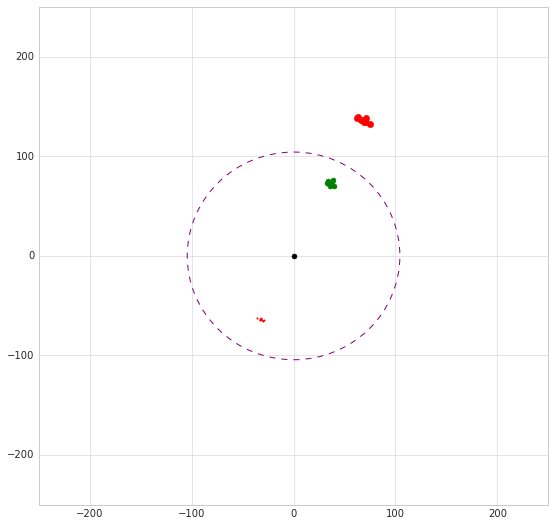

In [151]:
fig,ax = subplots(1,1)
fig.tight_layout()
fig.set_size_inches(8,8)

ax.set_xlim(-250,250);
ax.set_ylim(-250,250);
ax.plot(0,0,linestyle="none",marker=".", markersize=10,color="k");
ax.plot(source_x,source_y,linestyle="none",marker=".", markersize=10,color="g")

circ = plt.Circle((0,0), radius=tE_pix, linestyle="--",color='purple', fill=False)
ax.add_patch(circ);

i = 0;
while i < len(xprime1):
    ax.plot(xprime1[i],yprime1[i],linestyle="none",marker=".", markersize=10*mag1[i],color="r")
    ax.plot(xprime2[i],yprime2[i],linestyle="none",marker=".", markersize=10*mag2[i],color="r")
    i += 1;

Now let's make this more customizable and accepting of various sources, lens and distance parameters.

In [173]:
def einstein_pix():
    print("Hello! Welcome to this Gravitational Lensing Simulation. I'm going to ask you a few questions based on your model of interest.")
    mass = float(input("Please input the lensing mass in terms of Solar Masses: "))
    M_lens = 1.9891e30*mass; #kg
    G = 6.67e-11; #m^3/kg.s^2
    c = 2.99e8 #m/s
    N = ((4*M_lens*G/(c**2.0))*3.24e-23)**(0.5); #Mpc^1/2
    D_ls = float(input("Please input the distance from the source to the lensing mass in Mpc: "))
    D_l = float(input("Please input the distance from the observer to lens in Mpc: "))
    D_s = D_l + D_ls;
    theta_E = N*((D_ls/D_s*D_l)**(0.5));
    pix = float(input("Please input the desired size of a pixel (0.00001 recommended): "))
    einstein_pix = theta_E/pix;
    print("The Einstein Radius in pixels for this model is: " + str(einstein_pix))
    return einstein_pix;

In [174]:
def inside_einstein():
    size = float(input("Please choose a radius for the source object in pixels: "))
    xc = random.uniform(0.0, erad)*random.choice([1,-1]);
    yc = random.uniform(0.0, erad)*random.choice([1,-1]);
    xsource = list(random.uniform(xc - size, xc + size,100));
    ysource = list(random.uniform(yc - size, yc + size,100));
    source = [xsource, ysource];
    return source;

In [175]:
def outside_einstein():
    size = float(input("Please choose a radius for the source object in pixels: "))
    dist = float(input("Please choose a small pixel distance for how far outside the Einstein Radius the source should be: "))
    xc = random.uniform(erad, erad + dist/2.0)*random.choice([1,-1]);
    yc = random.uniform(erad, erad + dist/2.0)*random.choice([1,-1]);
    xsource = list(random.uniform(xc - size, xc + size,100));
    ysource = list(random.uniform(yc - size, yc + size,100));
    source = [xsource, ysource];
    return source;

In [176]:
def beta_zero():
    size = float(input("Please choose a radius for the source object in pixels: "))
    xsource = list(random.uniform(0.0 + size, 0.0 - size,100));
    ysource = list(random.uniform(0.0 + size, 0.0 - size,100));
    source = [xsource, ysource];
    return source;

In [177]:
def source():
    print("You will now have three options to generate a background source to lens. Please reply yes if yes, anything for no.")
    answer = raw_input("Would you like to randomly generate a source within the Einstein Radius? ")
    if answer == "yes":
        source = inside_einstein();
        return source;
    answer = raw_input("Would you like to randomly generate a source outside the Einstein Radius? ")
    if answer == "yes":
        source = outside_einstein();
        return source;
    answer = raw_input("Would you like to randomly generate a source directly behind the lensing mass? ")
    if answer == "yes":
        source = beta_zero();
        return source;
    
    #didn't get to this :(
    #answer = input("Would you like to lens an image? ")
    #if answer == "yes":
    #    source = source_img();
    #    return source;

In [178]:
def lens(source, erad):
    fig,ax = subplots(1,1)
    fig.tight_layout()
    fig.set_size_inches(8,8)

    ax.set_title("Simulation")
    ax.set_xlim(-250,250);
    ax.set_ylim(-250,250);
    ax.plot(0,0,linestyle="none",marker=".", markersize=10,color="k",label="Lensing Mass");
    ax.plot(source[0],source[1],linestyle="none",marker=".", markersize=10,color="g",label="Source")

    circ = plt.Circle((0,0), radius=erad, linestyle="--",color='purple', fill=False, label="Einstein Ring")
    ax.add_patch(circ);
    ax.legend(loc=2)
    
    i = 0;
    while i < len(source[0]):
        x = source[0][i];
        y = source[1][i];
        beta = np.sqrt(x**2 + y**2);
        theta1 = 0.5*(beta + np.sqrt(beta**2+4*erad**2));
        theta2 = 0.5*(beta - np.sqrt(beta**2+4*erad**2));
        x1 = (theta1/beta)*x;
        y1 = (theta1/beta)*y;
        x2 = (theta2/beta)*x;
        y2 = (theta2/beta)*y;
        
        mtest1 = abs(1 - (erad**4.0/theta1**4.0));
        mtest2 = abs(1 - (erad**4.0/theta2**4.0));
        tol = 0.25
        if (mtest1 < tol) or (mtest2 < tol):
            m1 = 1;
            m2 = 1;
        else:
            m1 = (1-(erad**4.0/theta1**4.0))**(-1);
            m2 = (1-(erad**4.0/theta2**4.0))**(-1);
            
        ax.plot(x1,y1,linestyle="none",marker=".", markersize=10*m1,color="r")
        ax.plot(x2,y2,linestyle="none",marker=".", markersize=10*m2,color="r")
        i += 1;

Hello! Welcome to this Gravitational Lensing Simulation. I'm going to ask you a few questions based on your model of interest.
Please input the lensing mass in terms of Solar Masses: 3e12
Please input the distance from the source to the lensing mass in Mpc: 3
Please input the distance from the observer to lens in Mpc: 5
Please input the desired size of a pixel (0.00001 recommended): 0.00001
The Einstein Radius in pixels for this model is: 104.012084825
You will now have three options to generate a background source to lens. Please reply yes if yes, anything for no.
Would you like to randomly generate a source within the Einstein Radius? yes
Please choose a radius for the source object in pixels: 10


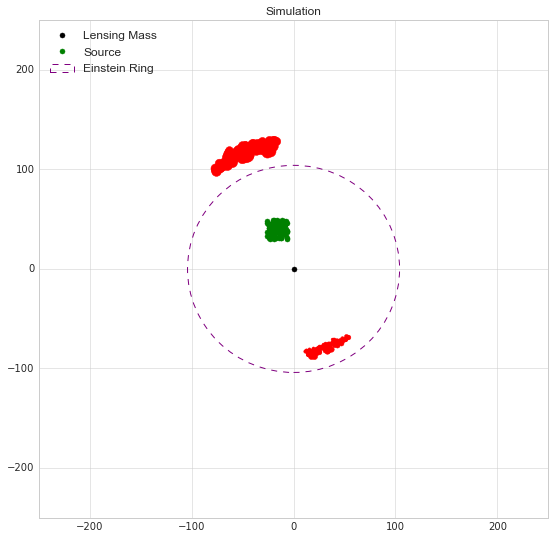

In [179]:
def grav_lens():
    erad = einstein_pix();
    s = source();
    lens(s, erad)
    
grav_lens()

Hello! Welcome to this Gravitational Lensing Simulation. I'm going to ask you a few questions based on your model of interest.
Please input the lensing mass in terms of Solar Masses: 3e12
Please input the distance from the source to the lensing mass in Mpc: 3
Please input the distance from the observer to lens in Mpc: 5
Please input the desired size of a pixel (0.00001 recommended): 0.00001
The Einstein Radius in pixels for this model is: 104.012084825
You will now have three options to generate a background source to lens. Please reply yes if yes, anything for no.
Would you like to randomly generate a source within the Einstein Radius? no
Would you like to randomly generate a source outside the Einstein Radius? yes
Please choose a radius for the source object in pixels: 10
Please choose a small pixel distance for how far outside the Einstein Radius the source should be: 5


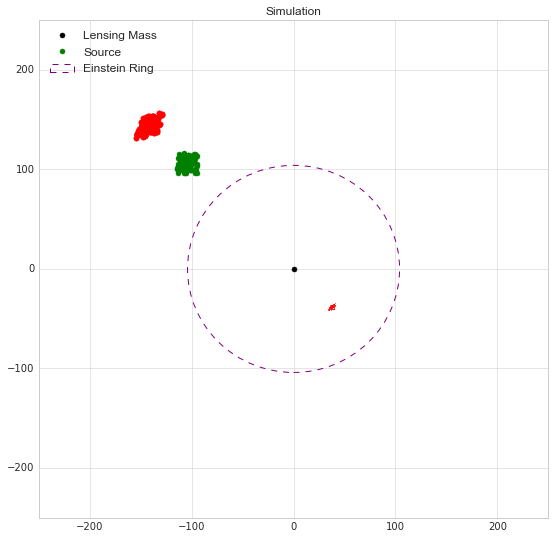

In [180]:
grav_lens()

Hello! Welcome to this Gravitational Lensing Simulation. I'm going to ask you a few questions based on your model of interest.
Please input the lensing mass in terms of Solar Masses: 3e12
Please input the distance from the source to the lensing mass in Mpc: 3
Please input the distance from the observer to lens in Mpc: 5
Please input the desired size of a pixel (0.00001 recommended): 0.00001
The Einstein Radius in pixels for this model is: 104.012084825
You will now have three options to generate a background source to lens. Please reply yes if yes, anything for no.
Would you like to randomly generate a source within the Einstein Radius? no
Would you like to randomly generate a source outside the Einstein Radius? no
Would you like to randomly generate a source directly behind the lensing mass? yes
Please choose a radius for the source object in pixels: 10


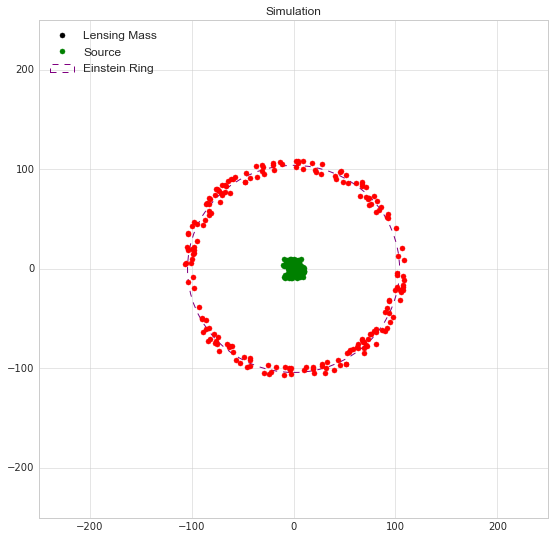

In [181]:
grav_lens()